<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula9a_dogs_vs_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

 99% 802M/812M [00:07<00:00, 145MB/s]
100% 812M/812M [00:07<00:00, 119MB/s]


In [4]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

In [5]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

In [7]:
def make_subset(subset_name, start_index, end_index):
  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
    for fname in fnames:
      shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

In [9]:
keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [10]:
from keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size = (180, 180),
    batch_size = 32
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size = (180, 180),
    batch_size = 32
)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size = (180, 180),
    batch_size = 32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [11]:
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [12]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "convnet_from_scratch.keras",
        save_best_only = True,
        monitor = "val_loss"
    )
]

In [14]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data = validation_dataset,
    callbacks = callbacks
)

Epoch 1/30
63/63 [==============================] - 18s 275ms/step - loss: 0.7034 - accuracy: 0.4960 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 17s 271ms/step - loss: 0.6940 - accuracy: 0.5245 - val_loss: 0.6910 - val_accuracy: 0.5080
Epoch 3/30
63/63 [==============================] - 17s 269ms/step - loss: 0.6889 - accuracy: 0.5520 - val_loss: 0.7014 - val_accuracy: 0.5070
Epoch 4/30
63/63 [==============================] - 17s 266ms/step - loss: 0.6662 - accuracy: 0.6035 - val_loss: 0.6470 - val_accuracy: 0.6300
Epoch 5/30
63/63 [==============================] - 17s 263ms/step - loss: 0.6349 - accuracy: 0.6510 - val_loss: 0.6602 - val_accuracy: 0.5970
Epoch 6/30
63/63 [==============================] - 17s 266ms/step - loss: 0.6148 - accuracy: 0.6735 - val_loss: 0.6635 - val_accuracy: 0.6280
Epoch 7/30
63/63 [==============================] - 17s 264ms/step - loss: 0.5830 - accuracy: 0.7010 - val_loss: 0.5947 - val_accuracy: 0.6670

In [15]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 4s 58ms/step - loss: 0.6092 - accuracy: 0.6705
TEst accuracy: 0.670


<Figure size 640x480 with 0 Axes>

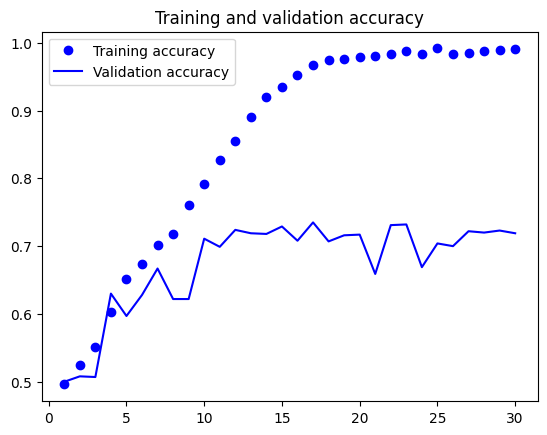

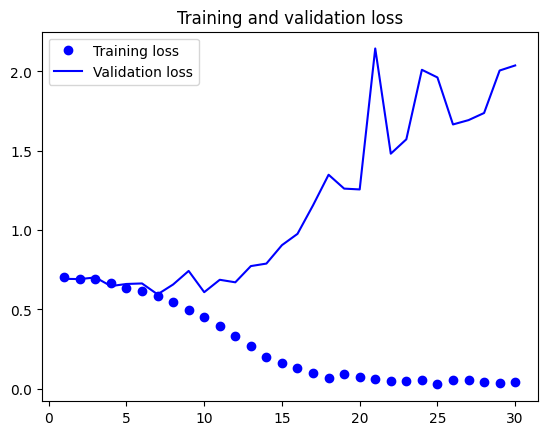

<Figure size 640x480 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy)+1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.figure()

In [18]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

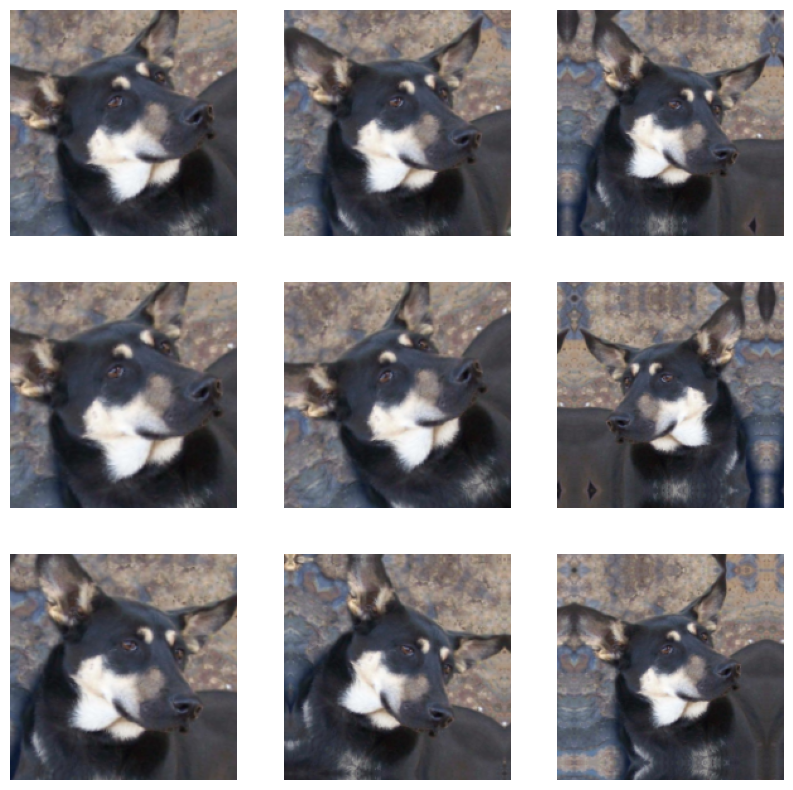

In [19]:
plt.figure(figsize=(10,10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [20]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                           

In [21]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "convnet_from_scratch_with_augmentation.keras",
        save_best_only = True,
        monitor = "val_loss"
    )
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data = validation_dataset,
    callbacks = callbacks
)

Epoch 1/100
63/63 [==============================] - 18s 275ms/step - loss: 0.6952 - accuracy: 0.5070 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 17s 273ms/step - loss: 0.6940 - accuracy: 0.5010 - val_loss: 0.6912 - val_accuracy: 0.5030
Epoch 3/100
63/63 [==============================] - 17s 273ms/step - loss: 0.6913 - accuracy: 0.5420 - val_loss: 0.6912 - val_accuracy: 0.5110
Epoch 4/100
63/63 [==============================] - 17s 272ms/step - loss: 0.6865 - accuracy: 0.5650 - val_loss: 0.6807 - val_accuracy: 0.5560
Epoch 5/100
63/63 [==============================] - 17s 273ms/step - loss: 0.6702 - accuracy: 0.5955 - val_loss: 0.6413 - val_accuracy: 0.6320
Epoch 6/100
63/63 [==============================] - 17s 271ms/step - loss: 0.6609 - accuracy: 0.6160 - val_loss: 0.6677 - val_accuracy: 0.6210
Epoch 7/100
63/63 [==============================] - 17s 269ms/step - loss: 0.6432 - accuracy: 0.6390 - val_loss: 0.6252 - val_accuracy:

In [23]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 4s 55ms/step - loss: 0.4232 - accuracy: 0.8500
Test accuracy: 0.850


<Figure size 640x480 with 0 Axes>

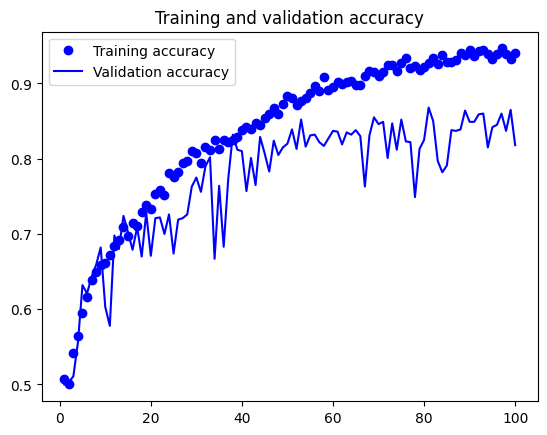

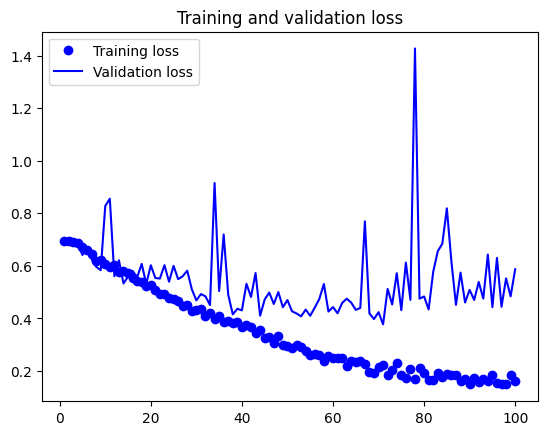

<Figure size 640x480 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy)+1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.figure()

In [25]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False
conv_base.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [32]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
# x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_4 (Flatten)         (None, 12800)             0         
                                                                 
 dense_5 (Dense)             (None, 256)               3277056   
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 257 

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "feature_extraction_with_augmentation.keras",
        save_best_only = True,
        monitor = "val_loss"
    )
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data = validation_dataset,
    callbacks = callbacks
)

Epoch 1/50
63/63 [==============================] - 38s 582ms/step - loss: 27.8875 - accuracy: 0.8420 - val_loss: 8.4773 - val_accuracy: 0.9410
Epoch 2/50
63/63 [==============================] - 36s 579ms/step - loss: 11.6063 - accuracy: 0.9220 - val_loss: 11.9536 - val_accuracy: 0.9370
Epoch 3/50
63/63 [==============================] - 37s 587ms/step - loss: 11.8736 - accuracy: 0.9120 - val_loss: 5.2290 - val_accuracy: 0.9570
Epoch 4/50
63/63 [==============================] - 37s 585ms/step - loss: 8.2837 - accuracy: 0.9295 - val_loss: 6.1279 - val_accuracy: 0.9480
Epoch 5/50
63/63 [==============================] - 37s 589ms/step - loss: 7.1287 - accuracy: 0.9350 - val_loss: 6.2526 - val_accuracy: 0.9500
Epoch 6/50
63/63 [==============================] - 37s 590ms/step - loss: 4.9480 - accuracy: 0.9415 - val_loss: 7.8459 - val_accuracy: 0.9430
Epoch 7/50
63/63 [==============================] - 36s 581ms/step - loss: 4.8340 - accuracy: 0.9415 - val_loss: 8.0510 - val_accuracy: 0.

In [ ]:
test_model = keras.models.load_model("feature_extraction_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

#Fine-tuning

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
  layer.trainable = False

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
# x = keras.applications.vgg16.VGG16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
model.summary()

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "fine_tuning.keras",
        save_best_only = True,
        monitor = "val_loss"
    )
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data = validation_dataset,
    callbacks = callbacks
)

In [ ]:
test_model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")